# Estimation paramétrique univariée

## Import des outils / jeu de données

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from lifelines import (
    ExponentialFitter,
    GeneralizedGammaFitter,
    LogLogisticFitter,
    LogNormalFitter,
    PiecewiseExponentialFitter,
    WeibullFitter,
)
from lifelines.plotting import qq_plot
from lifelines.utils import find_best_parametric_model
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import kstest

from src.modelisation.univariate.non_parametric.models import (
    create_hazard_models,
    create_survival_models,
)
from src.modelisation.univariate.parametric.models import create_models
from src.modelisation.univariate.parametric.plot import (
    plot_hazard_estimation,
    plot_hazard_estimations,
    plot_survival_estimation,
    plot_survival_estimations,
)
from src.utils import init_notebook

In [ ]:
init_notebook()

In [ ]:
df = pd.read_csv(
    "data/kickstarter_1.csv",
    parse_dates=True,
)

In [ ]:
event_times = df["day_succ"]
event_observed = df["Status"]

event_times_no_censoring = df["day_succ"][df["Status"] == 1]
event_observed_no_censoring = df["Status"][df["Status"] == 1]
df_video = df[df["has_video"] == 1].copy()
df_no_video = df[df["has_video"] == 0].copy()

t_video = df_video["day_succ"]
o_video = df_video["Status"]

t_no_video = df_no_video["day_succ"]
o_no_video = df_no_video["Status"]

In [ ]:
models = create_models()

## Modèles paramétriques testés

In [ ]:
tableau = {
    "Modèles paramétriques testées": [
        """- Weibull
- Exponentiel
- Exponentiel par morceaux
- Log-normal
- Log-logistique
- Gamma généralisé"""
    ],
    "**Critère de sélection**": [
        """- test de Kolmogorov-Smirnov
- QQ Plots
- AIC
- BIC"""
    ],
}

In [ ]:
# print(pd.DataFrame(tableau).to_markdown(index=False))

**Tableau.** Notre démarche pour les modèles paramétriques.

| Modèles paramétriques testées   | **Critère de sélection**     |
|:--------------------------------|:-----------------------------|
| - Weibull                       | - test de Kolmogorov-Smirnov |
| - Exponentiel                   | - QQ Plots                   |
| - Exponentiel par morceaux      | - AIC                        |
| - Log-normal                    | - BIC                        |
| - Log-logistique                |                              |
| - Gamma généralisé              |                              |


## Tests statistiques sur les distributions

### Histogrammes

Text(0.5, 0, 'Nombre de jours avant le succès du projet')

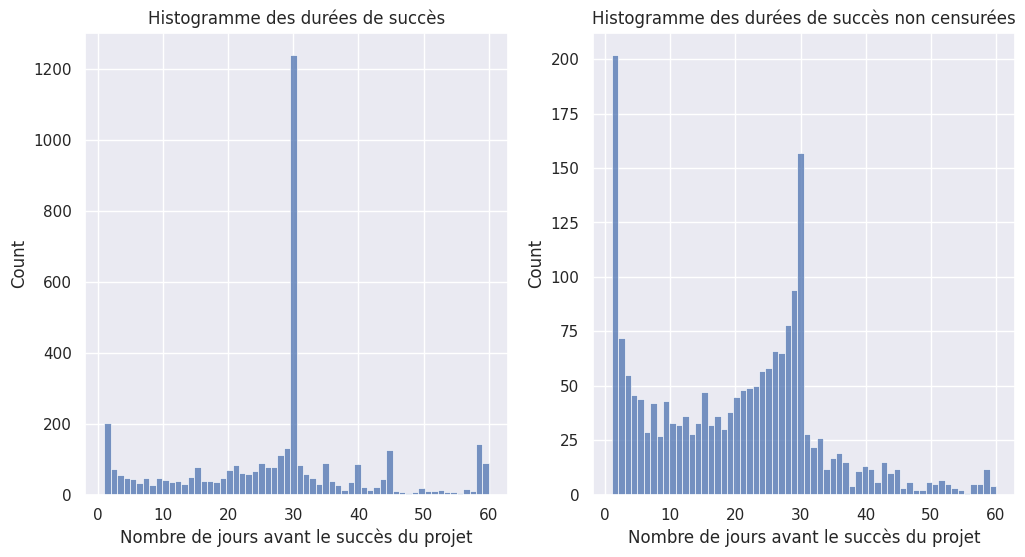

In [ ]:
_, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(event_times, ax=axs[0], bins=60)
axs[0].set_title("Histogramme des durées de succès")
axs[0].set_xlabel("Nombre de jours avant le succès du projet")

sns.histplot(event_times_no_censoring, ax=axs[1], bins=60)
axs[1].set_title("Histogramme des durées de succès non censurées")
axs[1].set_xlabel("Nombre de jours avant le succès du projet")

A première vue, la variable aléatoire de la durée s'écoulant avant le succès du projet ne suit pas une loi particulière.  

### Tests

Le test bilatéral de Kolmogorov-Smirnov, implémenté dans *scipy*, teste les hypothèse suivantes:  

$H_0: F(t) = G(t), \hspace{10px} \forall t$  
$H_1: F(t) \neq G(t), \hspace{10px} \forall t$ 

In [ ]:
mean = np.mean(event_times)
std = np.std(event_times)

ks_norm, p_value_norm = kstest(
    rvs=event_times,  # Random variable to test
    cdf=stats.norm.cdf,  # Reference CDF
    args=(mean, std),  # Reference distribution parameters
)

print(f"Gaussian distribution p-value = {p_value_norm}")

Gaussian distribution p-value = 7.382711171697771e-103


In [ ]:
ks_weibull, p_value_weibull = kstest(
    rvs=event_times,  # Random variable to test
    cdf=stats.weibull_min.cdf,  # Reference CDF
    args=(1.5,),  # Reference distribution parameters
)

print(f"Weibull distribution p-value = {p_value_weibull}")

Weibull distribution p-value = 0.0


In [ ]:
log_mean = np.log(mean)
log_std = np.log(std)

ks_lognorm, p_value_lognorm = kstest(
    rvs=event_times,  # Random variable to test
    cdf=stats.lognorm.cdf,  # Reference CDF
    args=(1,),  # Reference distribution parameters
)

print(f"Log-normal distribution p-value = {p_value_lognorm}")

Log-normal distribution p-value = 0.0


In [ ]:
ks_gamma, p_value_gamma = kstest(
    rvs=event_times,  # Random variable to test
    cdf=stats.gamma.cdf,  # Reference CDF
    args=(1,),  # Reference distribution parameters
)

print(f"Gamma distribution p-value = {p_value_gamma}")

Gamma distribution p-value = 0.0


In [ ]:
p_value_dict = {
    "Distribution testée": [
        "Weibull",
        "Exponentiel",
        "Log-normale",
        "Log-logistique",
        "Gamma généralisée",
    ],
    "p-value": [0, 0, 0, 0, 0],
}

In [ ]:
df_p_value = pd.DataFrame(p_value_dict)

In [ ]:
# print(df_p_value.to_markdown(index=False))

**Tableau.** Distributions testées et p-values obtenues.

| Distribution testée   |   p-value |
|:----------------------|----------:|
| Weibull               |         0 |
| Exponentiel           |         0 |
| Log-normale           |         0 |
| Log-logistique        |         0 |
| Gamma généralisée     |         0 |



Comme attendu, la fonction de survie ne suit pas une loi particulière.

## Fonction de survie

### Modèles paramétriques

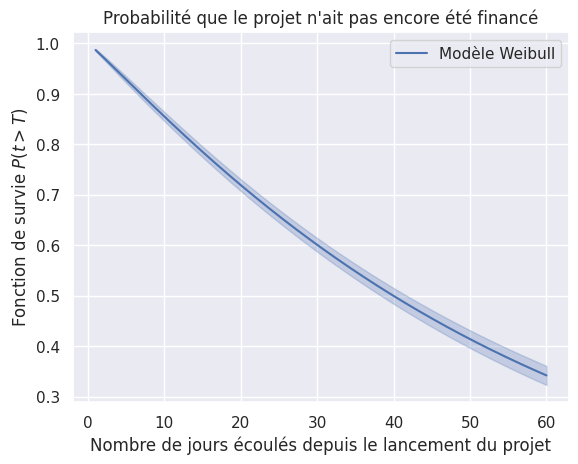

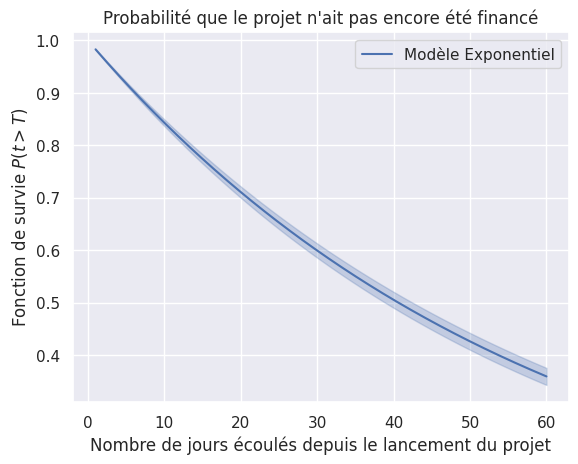

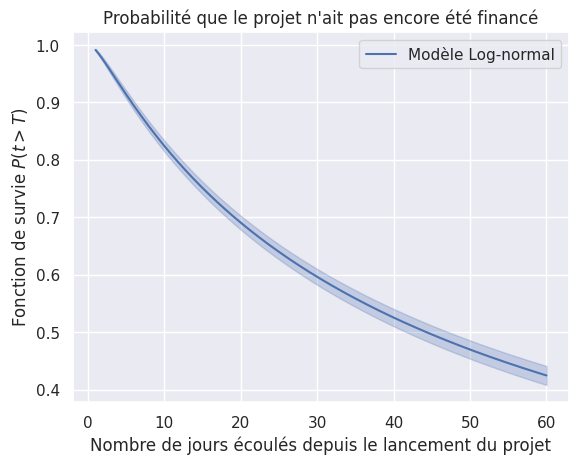

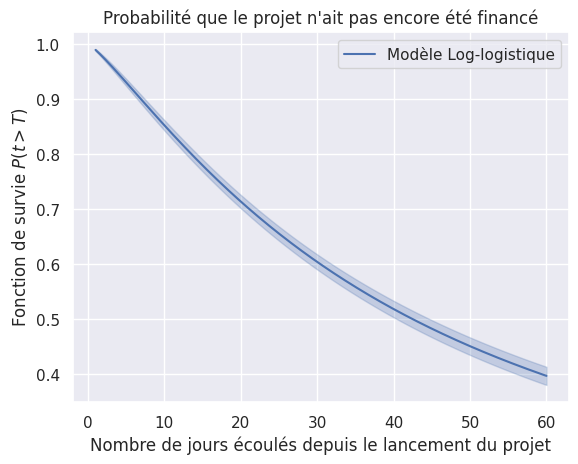

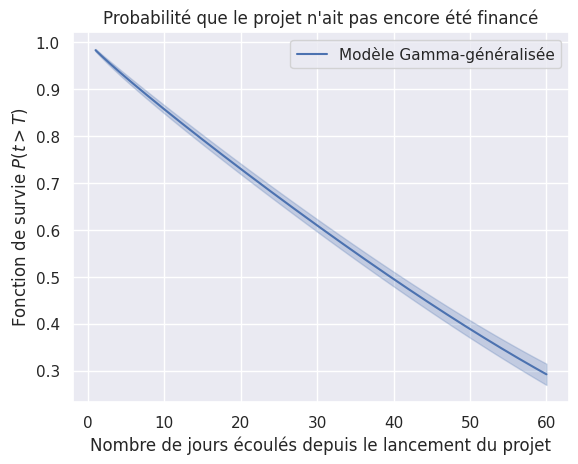

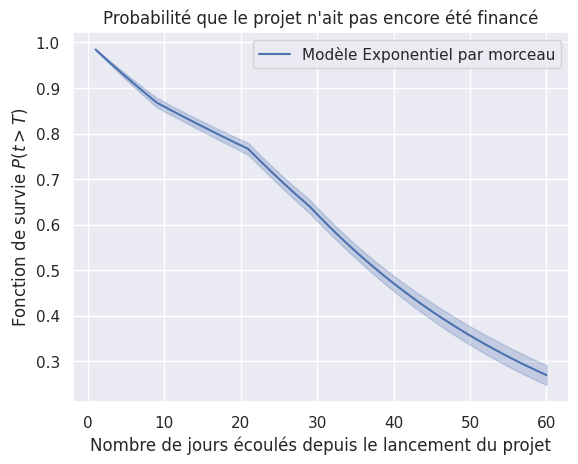

In [ ]:
plot_survival_estimations(models, event_times, event_observed)

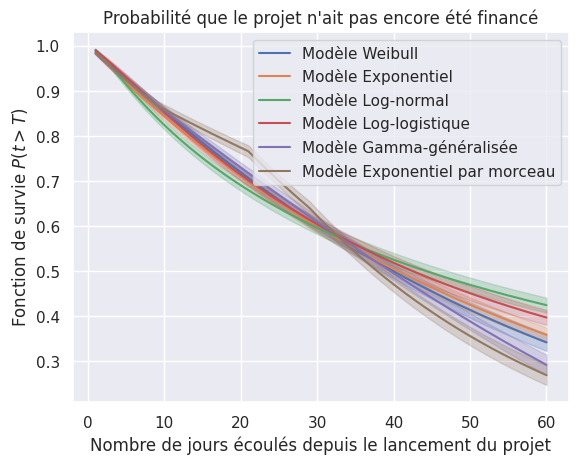

In [ ]:
# todo tracer kaplam meier et test de logrank
plot_survival_estimations(models, event_times, event_observed, same_plot=True)

### Impact de la censure

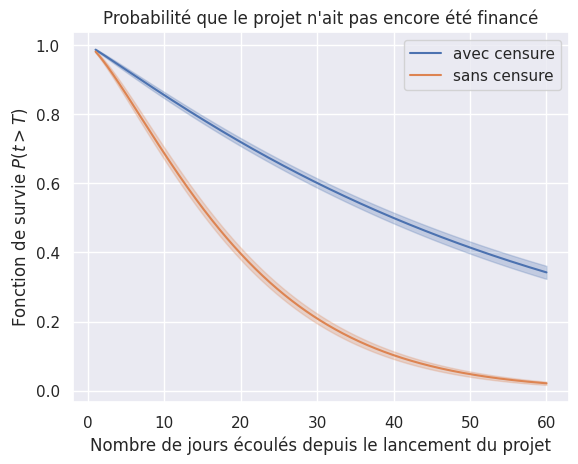

In [ ]:
plot_survival_estimation(models["Weibull"], event_times, event_observed, "avec censure")
plot_survival_estimation(
    models["Weibull"],
    event_times_no_censoring,
    event_observed_no_censoring,
    "sans censure",
)

### Comparaison avec modèles non-paramétriques

In [ ]:
km = create_survival_models()["Kaplan-Meier"]

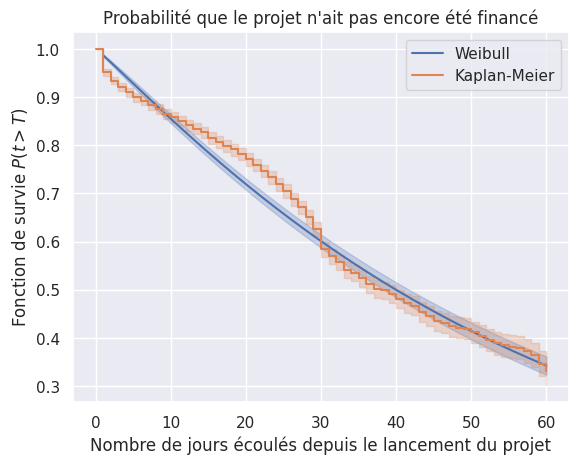

In [ ]:
plot_survival_estimation(models["Weibull"], event_times, event_observed, "Weibull")
plot_survival_estimation(km, event_times, event_observed, "Kaplan-Meier")

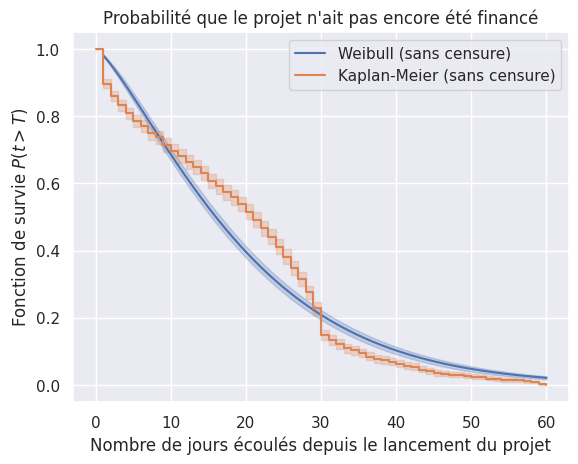

In [ ]:
plot_survival_estimation(
    models["Weibull"],
    event_times_no_censoring,
    event_observed_no_censoring,
    "Weibull (sans censure)",
)
plot_survival_estimation(
    km,
    event_times_no_censoring,
    event_observed_no_censoring,
    "Kaplan-Meier (sans censure)",
)

### Co-variables

#### Vidéo de présentation

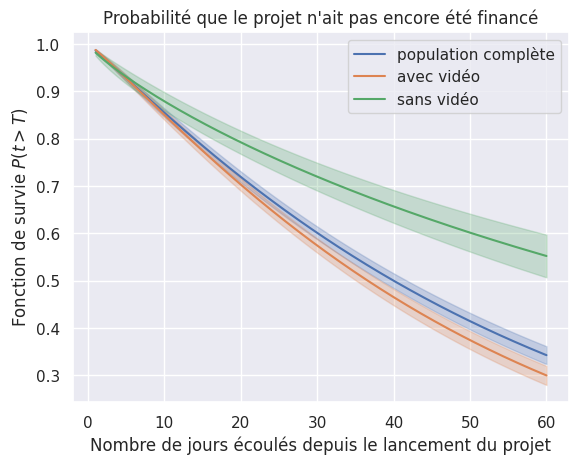

In [ ]:
plot_survival_estimation(
    models["Weibull"], event_times, event_observed, "population complète"
)
plot_survival_estimation(models["Weibull"], t_video, o_video, "avec vidéo")
plot_survival_estimation(models["Weibull"], t_no_video, o_no_video, "sans vidéo")

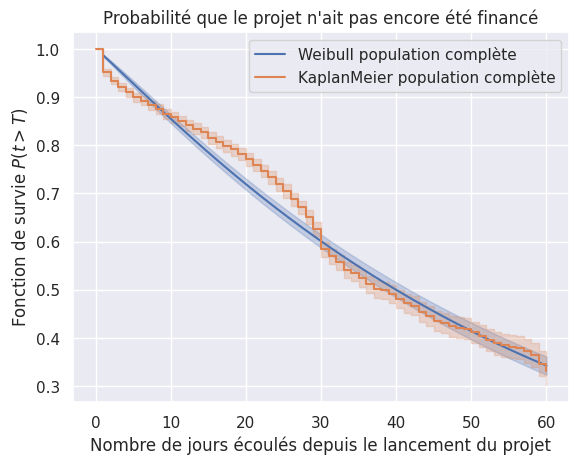

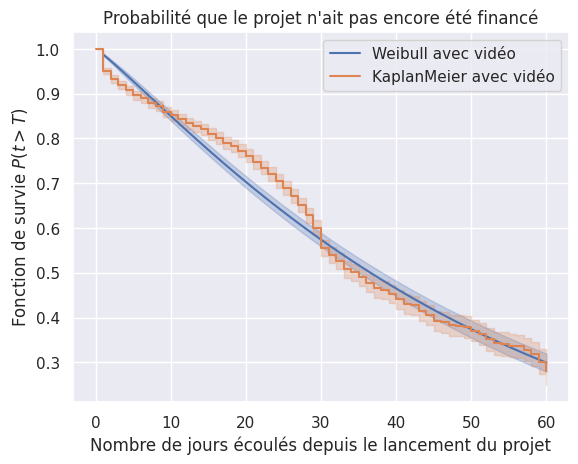

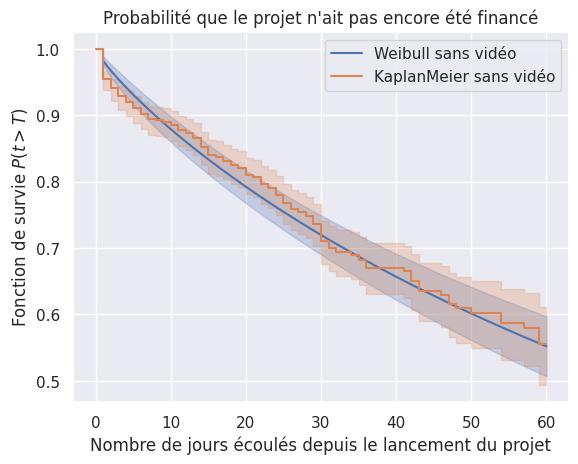

In [ ]:
for model in (models["Weibull"], km):
    name = model.__class__.__name__.replace("Fitter", "")
    plot_survival_estimation(
        model, event_times, event_observed, f"{name} population complète"
    )
plt.show()
for model in (models["Weibull"], km):
    name = model.__class__.__name__.replace("Fitter", "")
    plot_survival_estimation(model, t_video, o_video, f"{name} avec vidéo")

plt.show()
for model in (models["Weibull"], km):
    name = model.__class__.__name__.replace("Fitter", "")
    plot_survival_estimation(model, t_no_video, o_no_video, f"{name} sans vidéo")

## Fonction de risque

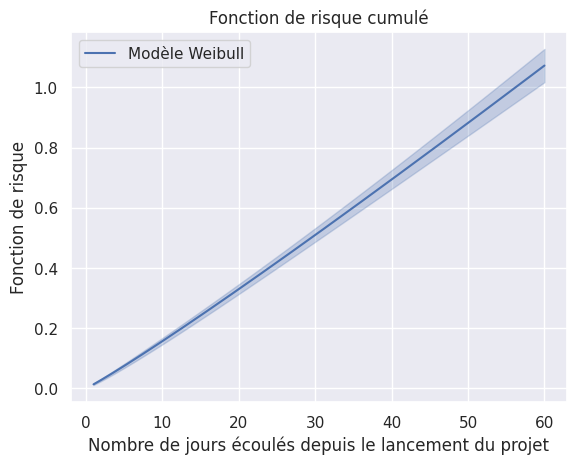

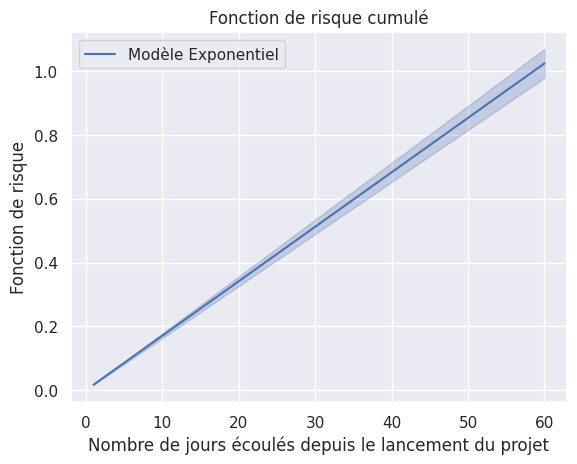

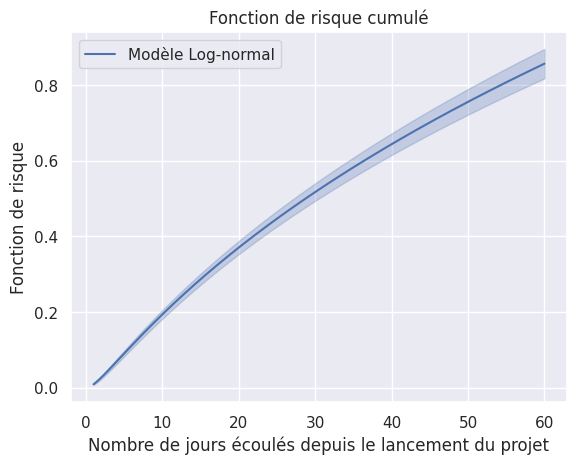

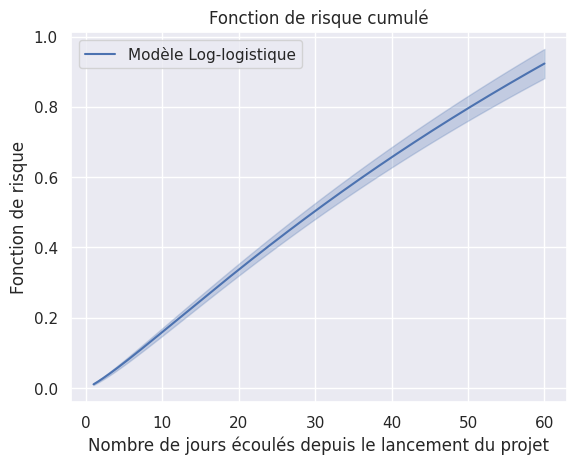

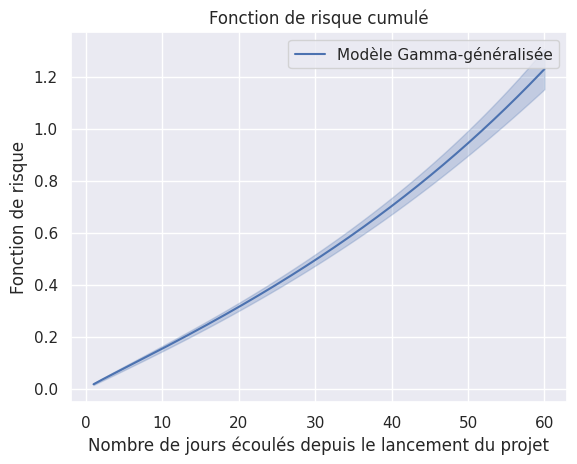

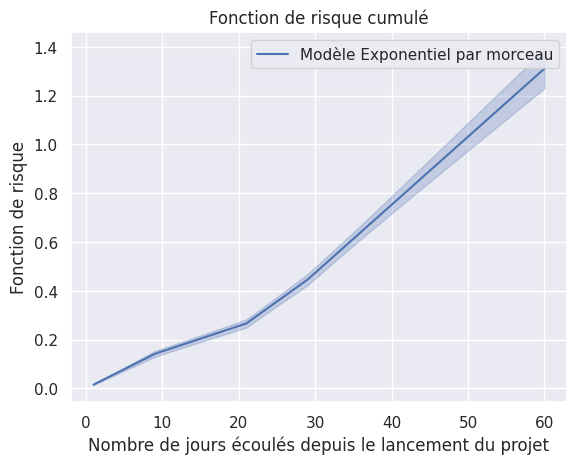

In [ ]:
plot_hazard_estimations(models, event_times, event_observed)

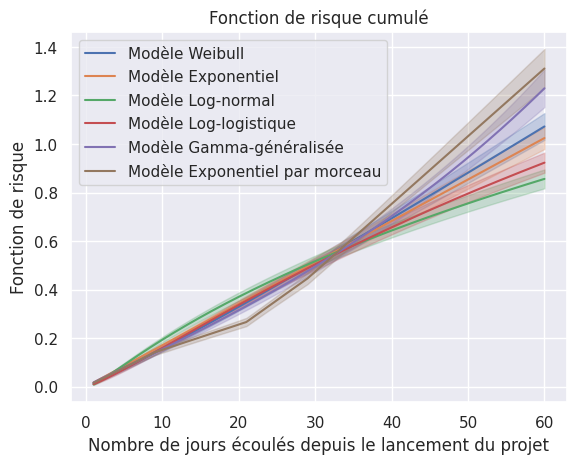

In [ ]:
plot_hazard_estimations(models, event_times, event_observed, same_plot=True)

### Impact de la censure

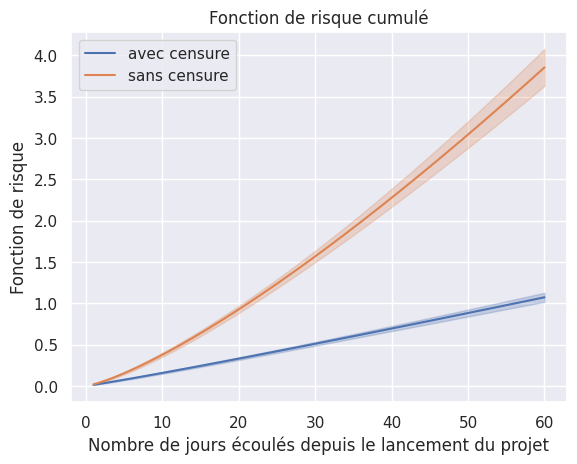

In [ ]:
plot_hazard_estimation(models["Weibull"], event_times, event_observed, "avec censure")
plot_hazard_estimation(
    models["Weibull"],
    event_times_no_censoring,
    event_observed_no_censoring,
    "sans censure",
)

### Co-variables

#### Vidéo de présentation

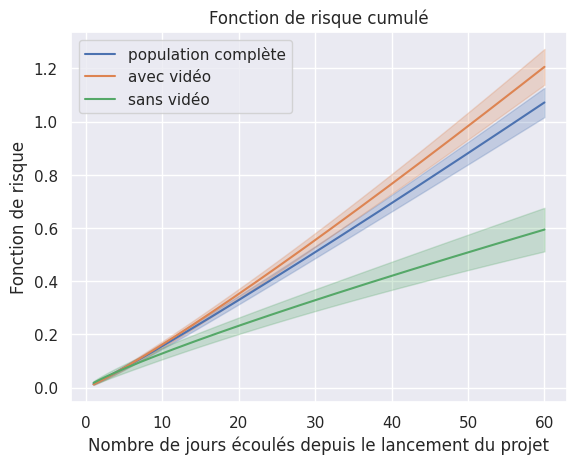

In [ ]:
plot_hazard_estimation(
    models["Weibull"], event_times, event_observed, "population complète"
)
plot_hazard_estimation(models["Weibull"], t_video, o_video, "avec vidéo")
plot_hazard_estimation(models["Weibull"], t_no_video, o_no_video, "sans vidéo")

## Comparaison de modèles paramétriques

<lifelines.PiecewiseExponentialFitter:"PiecewiseExponentialFitter: 3 breakpoint", fitted with 4175 total observations, 2213 right-censored observations>


<Axes: >

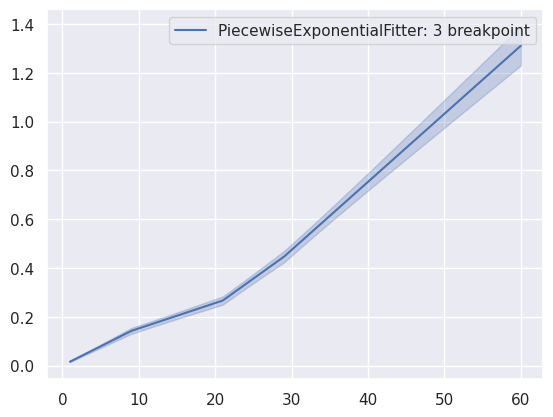

In [ ]:
best_model, best_aic_ = find_best_parametric_model(
    event_times, event_observed, scoring_method="AIC"
)

print(best_model)

best_model.plot_cumulative_hazard()

In [ ]:
best_model.breakpoints

array([ 9., 21., 29.])

### AIC, BIC et QQ Plots

$$\text{AIC}(\text{model}) = -2 \ln{L} + 2k$$

avec $k$ le nombre de paramètres (degrés de liberté) du modèle
et $L$ la vraisemblance

$$\text{BIC}(\text{model}) = -2 \ln{L} + k \cdot \ln N$$

avec $k$ le nombre de paramètres (degrés de liberté) du modèle,
$L$ la vraisemblance
et $N$ le nombre d'observations

In [ ]:
def qq_plots(event_times: pd.Series, event_observed: pd.Series) -> tuple[dict, dict]:
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.reshape(4)

    aic_dict = {}
    bic_dict = {}

    for i, model in enumerate(
        [
            PiecewiseExponentialFitter([9, 21, 29]),
            WeibullFitter(),
            LogNormalFitter(),
            LogLogisticFitter(),
            ExponentialFitter(),
            GeneralizedGammaFitter(),
        ]
    ):
        model.fit(event_times, event_observed)

        if not isinstance(model, PiecewiseExponentialFitter) and not isinstance(
            model, GeneralizedGammaFitter
        ):
            qq_plot(model, ax=axes[i - 1])

        model_name = model.__class__.__name__
        model_name = model_name.replace("Fitter", "")

        aic_dict[model_name] = model.AIC_
        bic_dict[model_name] = model.BIC_

    return aic_dict, bic_dict

#### QQ Plots

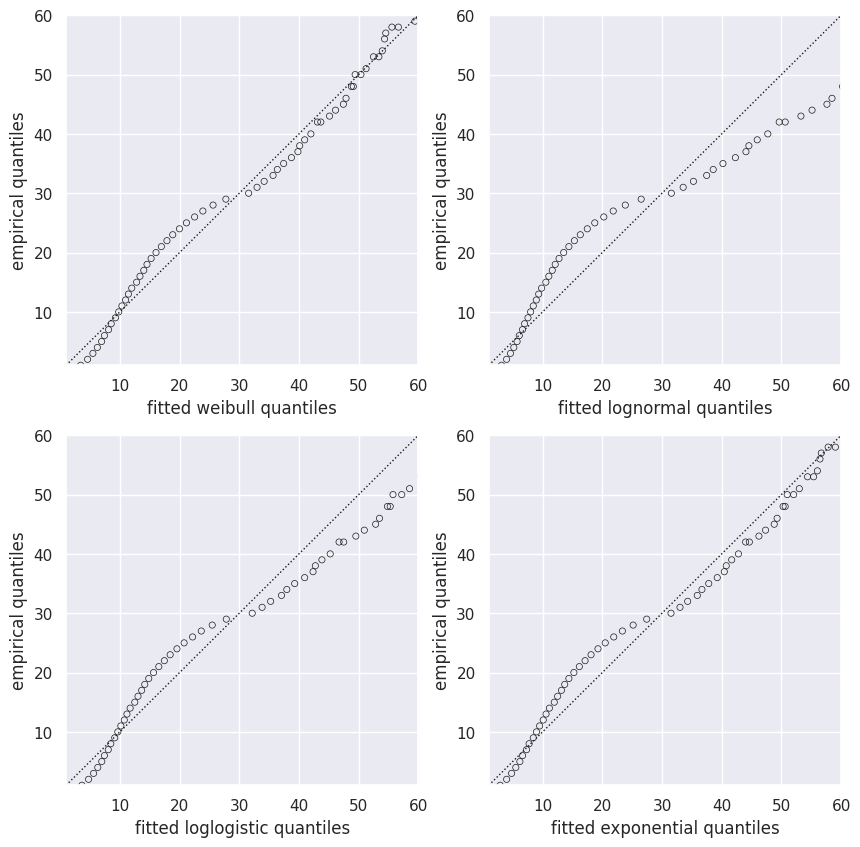

In [ ]:
aic_dict, bic_dict = qq_plots(event_times, event_observed)

#### AIC et BIC

In [ ]:
score_dict = {
    "Modèle": [],
    "Métrique": [],
    "Valeur": [],
}

In [ ]:
for model in aic_dict.keys():
    score_dict["Modèle"].append(model)
    score_dict["Métrique"].append("aic")
    score_dict["Valeur"].append(aic_dict[model])

    score_dict["Modèle"].append(model)
    score_dict["Métrique"].append("bic")
    score_dict["Valeur"].append(bic_dict[model])

In [ ]:
df_score = pd.DataFrame(score_dict)

In [ ]:
aic_df = df_score[df_score["Métrique"] == "aic"].sort_values("Valeur")

In [ ]:
bic_df = df_score[df_score["Métrique"] == "bic"].sort_values("Valeur")

In [ ]:
# print(aic_df.to_markdown(index=False))
# print(bic_df.to_markdown(index=False))

<Axes: title={'center': 'Comparaison des modèles paramétriques'}, xlabel='Modèle', ylabel='Valeur'>

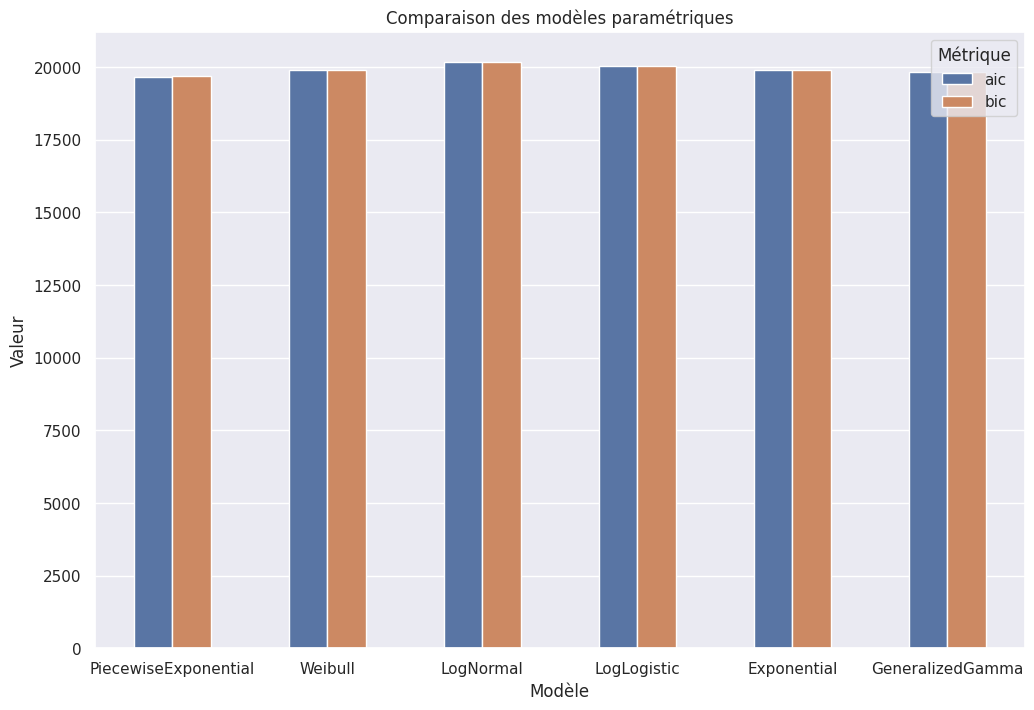

In [ ]:
plt.figure(figsize=(12, 8))
plt.title("Comparaison des modèles paramétriques")
sns.barplot(data=score_dict, x="Modèle", y="Valeur", hue="Métrique", width=0.5)

**Tableau.** AIC des modèles paramétriques (par ordre croissant)

| Modèle               |   AIC   |
|:---------------------|:-------:|
| PiecewiseExponential | 19651.1 |
| GeneralizedGamma     | 19818.2 |
| Weibull              | 19887.7 |
| Exponential          | 19897.5 |
| LogLogistic          | 20021.3 |
| LogNormal            | 20172.2 |

**Tableau.** BIC des modèles paramétriques (par ordre croissant)

| Modèle               |   BIC   |
|:---------------------|:-------:|
| PiecewiseExponential | 19676.5 |
| GeneralizedGamma     | 19837.2 |
| Weibull              | 19900.4 |
| Exponential          | 19903.8 |
| LogLogistic          | 20033.9 |
| LogNormal            | 20184.9 |

## Meilleur modèle paramétrique

**Tableau.** Récapitulatif des modèles paramétriques


| Modèle               | Test de<br/>Kolmogorov-Smirnov | QQ Plot |   AIC   |   BIC   |
|:---------------------|:------------------------------:|:-------:|:-------:|:-------:|
| Weibull              |               ❌                |    ✅    | 19887.7 | 19900.4 |
| Exponential          |               ❌                |    ✅    | 19897.5 | 19903.8 |
| PiecewiseExponential |               ❌                |    ✅    | 19651.1 | 19676.5 |
| LogNormal            |               ❌                |    ❌    | 20172.2 | 20184.9 |
| LogLogistic          |               ❌                |    ✅    | 20021.3 | 20033.9 |
| Gamma généralisé     |               ❌                |    ❌    | 19818.2 | 19837.2 |

**Choix du modèle paramétrique** : exponentiel par morceau

<Axes: title={'center': "Probabilité que le projet n'ait pas encore été financé"}, xlabel='Nombre de jours écoulés depuis le lancement du projet', ylabel='Fonction de survie $P(t > T)$'>

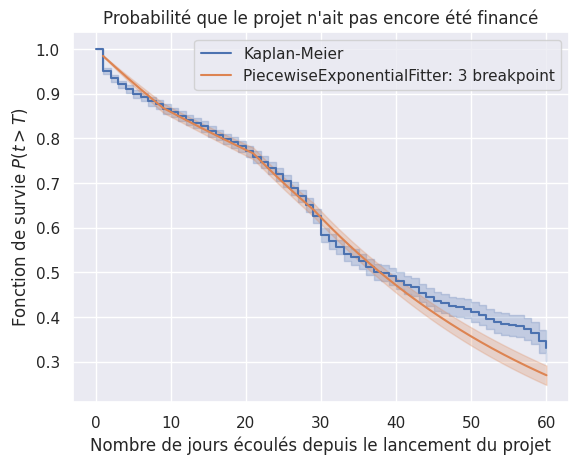

In [ ]:
plot_survival_estimation(km, event_times, event_observed, "Kaplan-Meier")
best_model.plot_survival_function()

<Axes: title={'center': 'Fonction de risque cumulé'}, xlabel='Nombre de jours écoulés depuis le lancement du projet', ylabel='Fonction de risque'>

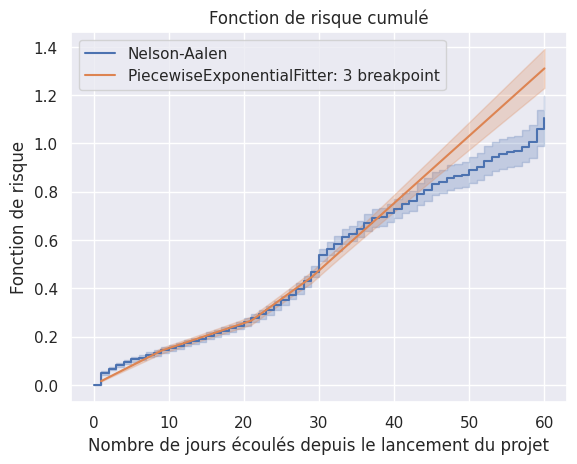

In [ ]:
hazard_models = create_hazard_models()

plot_hazard_estimation(
    hazard_models["Nelson-Aalen"], event_times, event_observed, "Nelson-Aalen"
)

best_model.plot_cumulative_hazard()

<Axes: title={'center': "Impact d'une vidéo promotionnelle :\nfonction de survie paramétrique\n(exponentielle par morceau)"}>

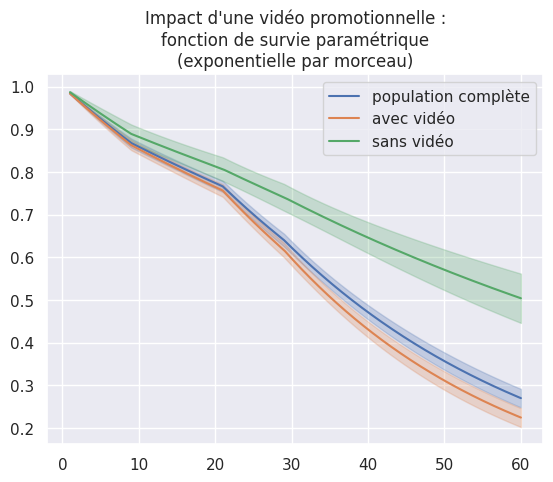

In [ ]:
plt.title(
    "Impact d'une vidéo promotionnelle :\nfonction de survie paramétrique\n(exponentielle par morceau)"
)

best_model.fit(event_times, event_observed)
best_model.plot_survival_function(label="population complète")

best_model.fit(t_video, o_video)
best_model.plot_survival_function(label="avec vidéo")

best_model.fit(t_no_video, o_no_video)
best_model.plot_survival_function(label="sans vidéo")